In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import layers, Input, models, optimizers
from keras.models import Model, Sequential
from keras.layers import MaxPooling2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
# generator = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range = 20,
#     width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     rescale = 1. / 255)

In [16]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(150,150, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
 
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
 
model.add(Dense(512, activation='relu'))
model.add(Dense(9, activation='softmax'))                                   # label, calss 갯수
model.summary()
 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 16)      432       
_________________________________________________________________
batch_normalization_13 (Batc (None, 150, 150, 16)      48        
_________________________________________________________________
activation_13 (Activation)   (None, 150, 150, 16)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 38, 38, 32)        4608      
_________________________________________________________________
batch_normalization_14 (Batc (None, 38, 38, 32)       

In [32]:
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


# 데이터 셋
train_datagen = ImageDataGenerator(rescale=1./255,
#                                    rotation_range=10,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    shear_range=0.7,
#                                    zoom_range=[0.9, 2.2],
#                                    horizontal_flip=True,
#                                    vertical_flip=True,
#                                    fill_mode='nearest',
                                   validation_split=0.33)
 
training_set = train_datagen.flow_from_directory('./data/clothes_category',
                                                 target_size = (150,150),
                                                 batch_size = 15,
                                                 class_mode = 'categorical',
                                                 subset="training"
                                                )
validation_set = train_datagen.flow_from_directory('./data/clothes_category',
                                                 target_size = (150,150),
                                                 batch_size = 10,
                                                 class_mode = 'categorical',
                                                 subset="validation"
                                                  )
 

Found 2905 images belonging to 9 classes.
Found 1424 images belonging to 9 classes.


In [30]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model_pattern_0424.h5', monitor='val_loss', mode='min', save_best_only=True)

In [33]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('./log.csv', append=True, separator=';')
 
 
hist = model.fit_generator(training_set,
                         steps_per_epoch = 10, #20
                         epochs = 500,  #1000
                         validation_data = validation_set,
                         validation_steps = 10,
                         callbacks=[es,mc])
 
 

Epoch 1/500
10/10 [==============================] - 8s 781ms/step - loss: 1.6341 - accuracy: 0.4533 - val_loss: 2.3868 - val_accuracy: 0.0800
Epoch 2/500
10/10 [==============================] - 5s 533ms/step - loss: 1.4791 - accuracy: 0.5400 - val_loss: 2.3119 - val_accuracy: 0.1000
Epoch 3/500
10/10 [==============================] - 5s 516ms/step - loss: 1.3223 - accuracy: 0.5267 - val_loss: 1.5625 - val_accuracy: 0.2700
Epoch 4/500
10/10 [==============================] - 5s 489ms/step - loss: 1.2491 - accuracy: 0.5533 - val_loss: 2.3202 - val_accuracy: 0.1600
Epoch 5/500
10/10 [==============================] - 5s 503ms/step - loss: 1.2629 - accuracy: 0.5667 - val_loss: 1.8086 - val_accuracy: 0.1900
Epoch 6/500
10/10 [==============================] - 5s 507ms/step - loss: 1.2339 - accuracy: 0.5733 - val_loss: 2.4044 - val_accuracy: 0.3000
Epoch 7/500
10/10 [==============================] - 5s 494ms/step - loss: 1.6333 - accuracy: 0.4276 - val_loss: 2.0240 - val_accuracy: 0.1000

In [ ]:
# 모델 저장


from keras.models import load_model, model_from_json
model.save('model_pattern.h5')                       # 모델(architecture, weight 동시 저장) 저장 이름


# 모델 아키텍처를 json 형, 식으로 저장                 # 모델 architecture 만 저장 
#json_string = model.to_json()                       # json 파일에서 모델 아키텍처 재구성
#model = model_from_json(json_string) 


# 모델 Weights 저장
#model.save_weights()


ModuleNotFoundError: No module named 'models'

In [ ]:
from keras.models import load_model
model = load_model('model_pattern.h5')

In [34]:
# output = classifier.predict_generator(test_set, steps=5)
# print(test_set.class_indices)
# print(output)
 
# 모델 평가하기
print("-- Evaluate --")
 
scores = model.evaluate_generator(
            validation_set,
            steps = 10)
 
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
 
# 모델 예측하기
print("-- Predict --")
 
output = model.predict_generator(
            validation_set,
            steps = 100)
print(validation_set.class_indices)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
 

-- Evaluate --
accuracy: 73.00%
-- Predict --
{'Chiffon_skirt': 0, 'Cotten_long_pants': 1, 'Cutoffs': 2, 'H_line_skirt': 3, 'Hoodie': 4, 'Jeans': 5, 'Long_sleeve_tee': 6, 'Shirts': 7, 'Short_sleeve_tee': 8}


In [ ]:
# 훈련 세트의 정확도와 테스트 세트의 정확도 사이의 차이는 과대적합(overfitting) 때문
# 과대적합은 머신러닝 모델이 훈련 데이터보다 새로운 데이터에서 성능이 낮아지는 현상

In [ ]:
# 모델 예측
# predict는 확률을, predict_classes는 label 값을 알려줌

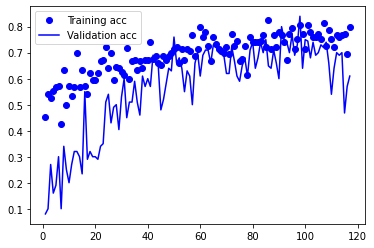

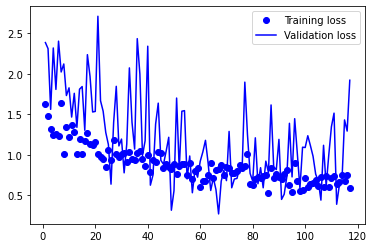

In [42]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
# plt.tilte('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
# plt.tilte('Training and validation loss')
plt.legend()

plt.show()

KeyError: 'acc'

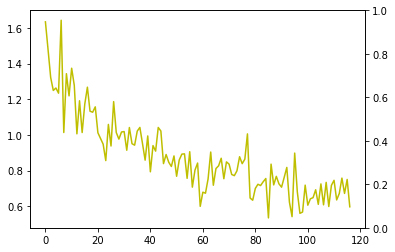

In [35]:
# 학습 과정 정확도, 손실함수 변화 그래프로 보기


import matplotlib.pyplot as plt
 
fig, loss_ax = plt.subplots()
 
acc_ax = loss_ax.twinx()
 
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
##loss_ax.set_ylim([0.0, 0.5])
 
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
##acc_ax.set_ylim([0.8, 1.0])
 
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')
 
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
 
plt.show()

In [ ]:
# 모델 architecture 보기


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# moniter: 대상 값, mode: min/max, verbose=1 설정시 언제 멈췄는지 출력
# patience: 성능없는 에폭 허용 범위, baseline: 값 설정

#es = EarlyStopping(monitor='val_loss', mode='min')
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)



In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_pattern.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
hist = model.fit_generator(training_set,
                         steps_per_epoch = 20, #20
                         epochs = 50,  #1000
                         validation_data = validation_set,
                         validation_steps = 10,
                         callbacks=[es,mc])
 

Epoch 1/50
20/20 [==============================] - 59s 3s/step - loss: 1.3556 - acc: 0.5167 - val_loss: 1.5213 - val_acc: 0.4500
Epoch 2/50
20/20 [==============================] - 56s 3s/step - loss: 1.4636 - acc: 0.4500 - val_loss: 1.6483 - val_acc: 0.3900
Epoch 3/50
20/20 [==============================] - 57s 3s/step - loss: 1.3835 - acc: 0.4533 - val_loss: 1.7704 - val_acc: 0.3800
Epoch 4/50
20/20 [==============================] - 57s 3s/step - loss: 1.4579 - acc: 0.4667 - val_loss: 1.8449 - val_acc: 0.3200
Epoch 5/50
20/20 [==============================] - 59s 3s/step - loss: 1.3929 - acc: 0.5200 - val_loss: 1.6442 - val_acc: 0.3600
Epoch 6/50
20/20 [==============================] - 56s 3s/step - loss: 1.3999 - acc: 0.4667 - val_loss: 1.7846 - val_acc: 0.3200
Epoch 7/50
20/20 [==============================] - 56s 3s/step - loss: 1.4493 - acc: 0.4900 - val_loss: 2.0274 - val_acc: 0.3000
Epoch 8/50
20/20 [==============================] - 56s 3s/step - loss: 1.3620 - acc: 0.52